In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
from matplotlib_venn import venn2

# personal modules
import databases as db
import kuzmin_data_2018 as data_2018
import kuzmin_data_2020 as data_2020
import enrichment as enrich


In [2]:
dataset = "Kuzmin2018" # Kuzmin2020 or Kuzmin2018

if dataset == "Kuzmin2018":
    kuzmin_2018_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2018/data_files"
    kuzmin_2018_s1, kuzmin_2018_s1_digenic, kuzmin_2018_s1_trigenic = data_2018.load_kuzmin_2018_s1(kuzmin_2018_data_dir)

    costanzo_et_al_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/CostanzoEtAl2016/data_files/Data File S1. Raw genetic interaction datasets: Pair-wise interaction format"
    costanzo_data = data_2018.load_costanzo_data(costanzo_et_al_data_dir)
    #kuzmin_2020_s3, kuzmin_2020_s3_digenic = data.load_kuzmin_2020_s3(kuzmin_2020_data_dir)
    #kuzmin_2020_s5, kuzmin_2020_s5_singMut, kuzmin_2020_s5_dblMut = data.load_kuzmin_2020_s5(kuzmin_2020_data_dir)
    #kuzmin_2020_s2 = data.load_kuzmin_2020_s2(kuzmin_2020_data_dir)


    #print(kuzmin_2020_s1.combined_mutant_type.value_counts())
    #print(kuzmin_2020_s2.combined_mutant_type.value_counts())


    # f_i and f_j taken from costanzo, f_k taken from array allele in kuzmin 2018

    f_k_SMF = dict(zip(kuzmin_2018_s1_trigenic.array_allele_name, kuzmin_2018_s1_trigenic.array_single_mutant_fitness))

    s1 = pd.concat([costanzo_data.query_allele_name, costanzo_data.array_allele_name], axis=0)
    s2 = pd.concat([costanzo_data.query_smf, costanzo_data.array_smf], axis=0)
    df = pd.concat([s1, s2], axis=1).rename(columns={0:"allele", 1:"value"})
    df = df.drop_duplicates(subset=["allele"], keep='first').reset_index(drop=True)
    f_i_j_SMF = dict(zip(df.allele, df.value))

    # f_ij from query fitness in trigenic table
    # f_ik and f_jk from fitness digenic table
    f_ij_DMF = dict(zip(kuzmin_2018_s1_trigenic.query_allele_name, kuzmin_2018_s1_trigenic.query_single_double_mutant_fitness))
    f_ik_jk_DMF = dict(zip(kuzmin_2018_s1_digenic.alleles, kuzmin_2018_s1_digenic.query_single_double_mutant_fitness))

    #e_ik and e_jk come from the digenic portion of the Kuzmin 2018 S1 table
    e_ik_jk_DMF = dict(zip(kuzmin_2018_s1_digenic.alleles, kuzmin_2018_s1_digenic.raw_interaction_score_epsilon))

    f_i, f_j, f_k, f_ij, f_ik, f_jk, e_ik_kuz, e_jk_kuz = data_2018.consolidate_fitnesses_across_2018_tables(kuzmin_2018_s1_trigenic,
                                                                                                        f_k_SMF,
                                                                                                        f_i_j_SMF,
                                                                                                        f_ij_DMF,
                                                                                                        f_ik_jk_DMF,
                                                                                                        e_ik_jk_DMF)
                                                            
    df = kuzmin_2018_s1_trigenic

if dataset == "Kuzmin2020":
    kuzmin_2020_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2020"
    kuzmin_2020_s1, kuzmin_2020_s1_digenic, kuzmin_2020_s1_trigenic = data_2020.load_kuzmin_2020_s1(kuzmin_2020_data_dir)
    kuzmin_2020_s3, kuzmin_2020_s3_digenic = data_2020.load_kuzmin_2020_s3(kuzmin_2020_data_dir)
    kuzmin_2020_s5, kuzmin_2020_s5_singMut, kuzmin_2020_s5_dblMut = data_2020.load_kuzmin_2020_s5(kuzmin_2020_data_dir)
    kuzmin_2020_s2 = data_2020.load_kuzmin_2020_s2(kuzmin_2020_data_dir)


    print(kuzmin_2020_s1.combined_mutant_type.value_counts())
    print(kuzmin_2020_s2.combined_mutant_type.value_counts())

    kuzmin_2020_s1_dblMutFit = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.double_triple_mutant_fitness))
    kuzmin_2020_s1_epsilon = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.raw_interaction_score_epsilon))
    kuzmin_2020_s1_singMutFit = dict(zip(kuzmin_2020_s1.array_allele_name, kuzmin_2020_s1.array_single_mutant_fitness))

    kuzmin_2020_s3_singMutFit = dict(zip(kuzmin_2020_s3.array_allele_name, kuzmin_2020_s3.array_single_mutant_fitness))

    kuzmin_2020_s5_dblMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Double mutant"]
    kuzmin_2020_s5_singMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Single mutant"]

    kuzmin_2020_s5_dblMutFit = dict(zip(kuzmin_2020_s5_dblMut.alleles, kuzmin_2020_s5_dblMut.fitness))
    kuzmin_2020_s5_singMutFit = dict(zip(kuzmin_2020_s5_singMut.alleles, kuzmin_2020_s5_singMut.fitness))

    f_i, f_j, f_k, f_ij, f_ik, f_jk, e_ik_kuz, e_jk_kuz = data_2020.consolidate_fitnesses_across_tables(kuzmin_2020_s1_trigenic,
                                                                                            kuzmin_2020_s1_dblMutFit,
                                                                                            kuzmin_2020_s1_singMutFit,
                                                                                            kuzmin_2020_s1_epsilon,
                                                                                            kuzmin_2020_s3_singMutFit,
                                                                                            kuzmin_2020_s5_singMutFit,
                                                                                            kuzmin_2020_s5_dblMutFit)

    # incorporate fitnesses into the data frame so that for each triplet of genes, we have all relevant fitness values in the same row to calculate interactions
    # since we will be mostly using kuzmin_2020_s1_trigenic going forwards, lets rename it to df

    df = kuzmin_2020_s1_trigenic


digenic     537911
trigenic    256861
Name: combined_mutant_type, dtype: int64
digenic     7197
trigenic    4557
Name: combined_mutant_type, dtype: int64


In [3]:
names = ['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz']
vars = [f_i, f_j, f_k, f_ij, f_ik, f_jk, e_ik_kuz, e_jk_kuz]
for i in range(len(names)):
    n = names[i]
    v = vars[i]
    print(n, "\t", np.sum(np.isnan(np.array([i for i in v.values()]))))

f_i 	 30434
f_j 	 2098
f_k 	 0
f_ij 	 41244
f_ik 	 11
f_jk 	 88
e_ik_kuz 	 11
e_jk_kuz 	 88


#############################################################

AFTER THIS POINT ALL CODE IS REDUNDANT WITH THE 2020 ANALYSIS

#############################################################


In [4]:
df['f_ij'] = df['alleles'].map(f_ij)
df['f_ik'] = df['alleles'].map(f_ik)
df['f_jk'] = df['alleles'].map(f_jk)

df['f_i'] = df['alleles'].map(f_i)
df['f_j'] = df['alleles'].map(f_j)
df['f_k'] = df['alleles'].map(f_k)

df['e_ik_kuz'] = df['alleles'].map(e_ik_kuz)
df['e_jk_kuz'] = df['alleles'].map(e_jk_kuz)

In [5]:
print(np.sum(~np.isnan(df.f_ij)))
print(np.sum(~np.isnan(df.f_ik)))
print(np.sum(~np.isnan(df.f_jk)))
print(np.sum(~np.isnan(df.f_i)))
print(np.sum(~np.isnan(df.f_j)))
print(np.sum(~np.isnan(df.f_k)))
print()
print(np.sum(~np.isnan(df.e_ik_kuz)))
print(np.sum(~np.isnan(df.e_jk_kuz)))

#print(len(kuzmin_2020_s1_trigenic.f_ik))
print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])))
print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk'])))
print(len(df))
print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk']))/len(df))

215617
256850
256773
226427
254763
256861

256850
256773
189340
189340
256861
0.7371301988234882


fraction of tau values that remain after filtering out deviants
1.0


<ipython-input-6-d9d0c9f380e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tau_kuzmin_orig'] = df.double_triple_mutant_fitness - df.f_ij*df.f_k - df.e_ik_kuz*df.f_j - df.e_jk_kuz*df.f_i


,tau_kuzmin_orig,adjusted_interaction_score_epsilon_or_tau
tau_kuzmin_orig,1.000000,0.964925
adjusted_interaction_score_epsilon_or_tau,0.964925,1.000000


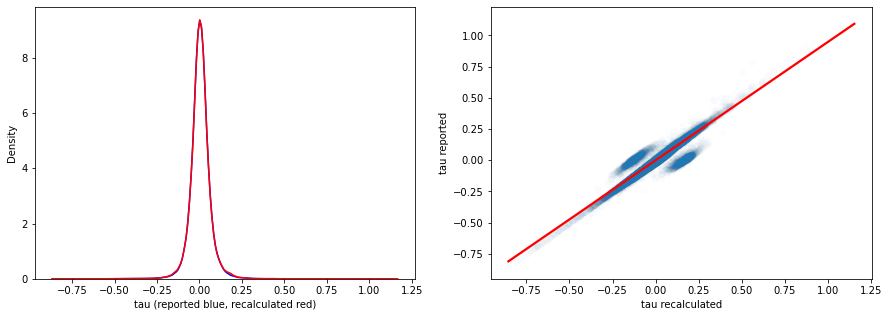

In [6]:
# To ensure we appropriately understand the data, we recalculate tau (trigenic interaction) using the formula in the supplement of Kuzmin 2018.
# These values *should* correspond to those reported in the 'adjusted_interaction_score_epsilon_or_tau' column. Around ~1% of recalculated tau values
# strongly deviate from those reported, and we filter these out.

df = df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])
threshold = 1

df['tau_kuzmin_orig'] = df.double_triple_mutant_fitness - df.f_ij*df.f_k - df.e_ik_kuz*df.f_j - df.e_jk_kuz*df.f_i

# filter out results that aren't reproducible according to the original equation
print("fraction of tau values that remain after filtering out deviants")
print(len(df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold])/len(df))

df = df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold]

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df['tau_kuzmin_orig'], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, recalculated red)')

p = sns.regplot(x=df['tau_kuzmin_orig'],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau recalculated', ylabel='tau reported')

df[['tau_kuzmin_orig', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")


In [7]:
df.loc[:, 'tau_cumulant'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk - df.f_j*df.f_ik - df.f_k*df.f_ij

df.loc[:,'e_ik_mult'] = df.f_ik/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult'] = df.f_jk/(df.f_j*df.f_k)
#df.loc[:,'tau_multiplicative'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult*df.e_jk_mult) 
df.loc[:,'tau_multiplicative'] = (df.double_triple_mutant_fitness*df.f_i*df.f_j*df.f_k)/(df.f_ij*df.f_ik*df.f_jk) 



# tau_cumulant (forumula from cumulant formula) calculated above should be equivalent to tau_kuzmin_orig (formula from Kuzmin et al 2018).
# One can substitute (f_jk - f_j*f_k) for e_jk and (f_ik - f_i*f_k) for e_ik into the Kuzmin et al 2018 formula to get the cumulant formula
# However, the results using these two equivalent formula aren't the same because  f_jk != (f_j*f_k + e_jk) and  f_ik != (f_i*f_k + e_ik)

# subsituting in (f_j*f_k + e_jk) for f_jk and (f_i*f_k + e_ik) for f_ik
# This gives trigenic interaction scores that are similar to reported values, see sanityChecks notebook
# newly recalculated double mutant fitnesses, and corresponding interactions, are suffixed with 2

df.loc[:, 'f_ik_2'] = df.f_i*df.f_k + df.e_ik_kuz
df.loc[:, 'f_jk_2'] = df.f_j*df.f_k + df.e_jk_kuz

df.loc[df['f_ik_2'] < 0, ['f_ik_2']] = np.nan
df.loc[df['f_jk_2'] < 0, ['f_jk_2']] = np.nan

df.loc[:,'e_ik_mult2'] = df.f_ik_2/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult2'] = df.f_jk_2/(df.f_j*df.f_k)

df.loc[:, 'tau_cumulant2'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk_2 - df.f_j*df.f_ik_2 - df.f_k*df.f_ij

# calculate multiplicative results using the custom dbl mutant fitnesses that gave results consistent with those reported (above)
# compare these with tau_cumulant2
#df.loc[:,'tau_multiplicative2'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult2*df.e_jk_mult2) 
df.loc[:,'tau_multiplicative2'] = (df.double_triple_mutant_fitness*df.f_i*df.f_j*df.f_k)/(df.f_ij*df.f_ik_2*df.f_jk_2) 

,tau_cumulant2,adjusted_interaction_score_epsilon_or_tau
tau_cumulant2,1.000000,0.964894
adjusted_interaction_score_epsilon_or_tau,0.964894,1.000000


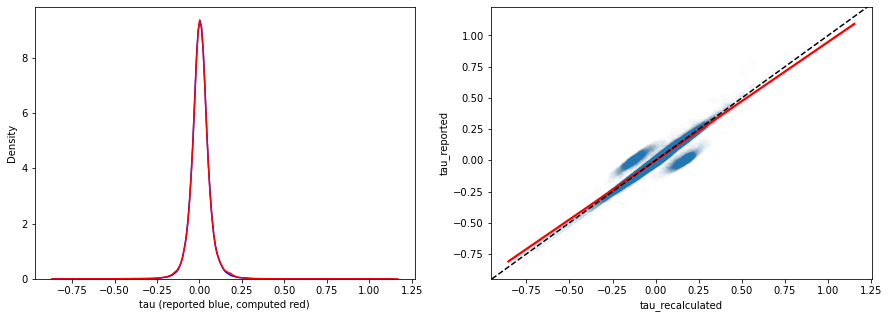

In [8]:
tau = "tau_cumulant2"

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df[tau], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, computed red)')

p = sns.regplot(x=df[tau],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_recalculated', ylabel='tau_reported')
axs[1].axline([-0.75, -0.75], [1, 1], linestyle="--", color="black")

df[[tau, 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")

In [9]:
# This logical switch is used to change all downstream analyses

use_reported_double_mutant_fitnesses = False
compare_to_reported_values = True # if False, compare instead to values recalculated with cumulant formula

if use_reported_double_mutant_fitnesses:
    multiplicative = "tau_multiplicative"
    cumulant = "tau_cumulant"
else:
    multiplicative = "tau_multiplicative2"
    cumulant = "tau_cumulant2"

if compare_to_reported_values:
    compare = "adjusted_interaction_score_epsilon_or_tau"
else:
    compare = cumulant

In [10]:
# To see how outliers vary across scales, we can calculate a significance threshold for the multiplicative scale by 
# finding the quantile that corresponds +/- 0.08, the trigenic score Kuzmin et al use to find positive/negative outliers.

tau_reported_sig_quant, tau_mult_sig_val, tau_iss_sig_val = {},{},{}

# get quantiles
tau_reported_sig_quant['neg'] = np.mean( np.array(df.adjusted_interaction_score_epsilon_or_tau) < -0.08)
tau_reported_sig_quant['pos'] = 1 - np.mean( np.array(df.adjusted_interaction_score_epsilon_or_tau) > 0.08)

# calculate significance thresholds on new scales using quantile
tau_mult_sig_val['neg'] = np.nanquantile(df[multiplicative], tau_reported_sig_quant['neg'])
tau_mult_sig_val['pos'] = np.nanquantile(df[multiplicative], tau_reported_sig_quant['pos'])

tau_iss_sig_val['neg'] = np.nanquantile(df[cumulant], tau_reported_sig_quant['neg'])
tau_iss_sig_val['pos'] = np.nanquantile(df[cumulant], tau_reported_sig_quant['pos'])

print("quantiles of the significant values they used",  tau_reported_sig_quant['neg'], tau_reported_sig_quant['pos'] )
print("confirming (should be -0.08):", np.quantile(df.adjusted_interaction_score_epsilon_or_tau, tau_reported_sig_quant['neg']))
print("confirming (should be 0.08):", np.quantile(df.adjusted_interaction_score_epsilon_or_tau, tau_reported_sig_quant['pos']))
print()
print( "corresponding cutoffs for multiplicative model: ", tau_mult_sig_val['neg'], tau_mult_sig_val['pos'])
print( "corresponding cutoffs for cumulant model: ", tau_iss_sig_val['neg'], tau_iss_sig_val['pos'])


quantiles of the significant values they used 0.050369705292067184 0.9306221611915073
confirming (should be -0.08): -0.07998675554557938
confirming (should be 0.08): 0.07998704066758214

corresponding cutoffs for multiplicative model:  0.9004959352506312 1.1117152250329532
corresponding cutoffs for cumulant model:  -0.08183026257546411 0.08153901494330401


/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


                                           tau_multiplicative2  \
tau_multiplicative2                                    1.00000   
adjusted_interaction_score_epsilon_or_tau              0.96368   

                                           adjusted_interaction_score_epsilon_or_tau  
tau_multiplicative2                                                          0.96368  
adjusted_interaction_score_epsilon_or_tau                                    1.00000  
                                           tau_multiplicative2  \
tau_multiplicative2                                   1.000000   
adjusted_interaction_score_epsilon_or_tau             0.896078   

                                           adjusted_interaction_score_epsilon_or_tau  
tau_multiplicative2                                                         0.896078  
adjusted_interaction_score_epsilon_or_tau                                   1.000000  
                                           tau_multiplicative2  \
tau_multiplica

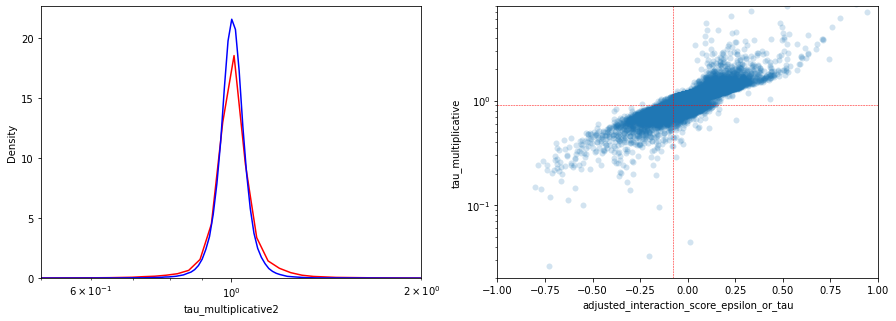

In [11]:
# How do multiplicative values compare to 

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

bw_param =10
p = sns.kdeplot(df[multiplicative], ax = axs[0], color="red", log_scale=True)
# add one so distributions are more comparable
p = sns.kdeplot(df[compare]+1, ax = axs[0], color="blue")
axs[0].set_xlim(0.5,2)

p = sns.scatterplot(x=df[compare],
            y=df[multiplicative],
            alpha=0.2,
            linewidth=0,
            ax=axs[1])
p.set(xlabel=compare, ylabel='tau_multiplicative')
axs[1].set_xlim(-1,1)
axs[1].set_yscale('log')
axs[1].set_ylim(0.02,8)
axs[1].axhline(tau_mult_sig_val['neg'], color="red", linestyle="--", linewidth=0.5)
#axs[1].axhline(tau_mult_sig_val['pos'], color="red", linestyle="--", linewidth=0.5)
axs[1].axvline(-0.08, color="red", linestyle="--", linewidth=0.5)
#axs[1].axvline(0.08, color="red", linestyle="--", linewidth=0.5)

print(df[[multiplicative, compare]].corr(method="spearman"))
print(df[[multiplicative, compare]].corr(method="kendall"))
print(df[[multiplicative, compare]].corr(method="pearson"))


In [12]:
def count_frac(df):
    return len(df)
    
results = defaultdict(list)
p = 0.05

overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment( df[df.pval < p], "negative", count_frac, multiplicative, tau_mult_sig_val)
denom = overlap + only_reported + only_mult

results['type'].extend(['overlap', 'only reported', 'only multiplicative'])
results['number'].extend([overlap, only_reported, only_mult])
results['fraction'].extend([overlap/denom, only_reported/denom, only_mult/denom])

#overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment( df[df.pval < p], "positive", count_frac, multiplicative, tau_mult_sig_val)
#denom = overlap + only_reported + only_mult

#results['type'].extend(['overlap_positive', 'only reported positive', 'only mult positive'])
#results['number'].extend([overlap, only_reported, only_mult])
#results['fraction'].extend([overlap/denom, only_reported/denom, only_mult/denom])

pd.DataFrame.from_dict(results)

,type,number,fraction
0,overlap,1525,0.708973
1,only reported,106,0.049279
2,only multiplicative,520,0.241748


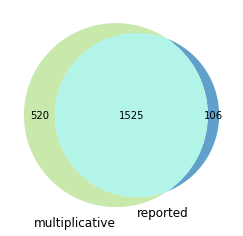

In [13]:
v = venn2(subsets = (only_mult, only_reported, overlap), set_labels = ('multiplicative', 'reported'), set_colors=('#b2df8a', '#1f78b4', '#a6cee3'), alpha = 0.7)

print(v)
plt.show()

In [14]:
# See if outliers are enriched for other biological signals. Here we load in pairwise physical interactions from one of two databases.
# 'physical_pairwise_interactions_set' contains a set of sorted 2-tuples of genes particupating in pairwise protein interactions

#physical_pairwise_interactions_set = db.get_physical_interactions_yeastGenomeDotOrg()

# BIOGRID contains physical interactions measured from a variety of assays including co-localization
# see here for explanation of experimental evidence codes: https://wiki.thebiogrid.org/doku.php/experimental_systems
db_interactions = db.get_physical_interactions_BIOGRID()
experimental_systems = ['Affinity Capture-MS', 'Affinity Capture-Western', 'Two-hybrid', 'Reconstituted Complex', 'PCA', 'Co-purification', 'Co-crystal Structure']
#experimental_systems = ['Affinity Capture-RNA']
#experimental_systems = ['Biochemical Activity']
#experimental_systems = ['Co-localization']
print(db_interactions.experimental_system.value_counts())

db_interactions = db_interactions[db_interactions.experimental_system.isin(experimental_systems)]
#db_interactions = db_interactions[db_interactions.experimental_system_type == "physical"]
#db_interactions

/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Negative Genetic                 419139
Affinity Capture-MS               95645
Positive Genetic                  83564
Synthetic Growth Defect           28938
Affinity Capture-RNA              27787
Affinity Capture-Western          21182
Two-hybrid                        19089
Synthetic Lethality               17342
Reconstituted Complex             10560
Synthetic Rescue                   9534
Phenotypic Enhancement             9265
Phenotypic Suppression             8930
Biochemical Activity               7400
PCA                                7311
Dosage Rescue                      6919
Co-purification                    5314
Dosage Lethality                   2277
Dosage Growth Defect               2244
Co-crystal Structure               1246
Co-fractionation                   1245
Proximity Label-MS                  939
Protein-peptide                     933
Co-localization                     898
Protein-RNA                         674
Synthetic Haploinsufficiency        307


In [15]:
physical_pairwise_interactions_set = db.find_unique_interactions(db_interactions, 'official_symbol_interactor_a', 'official_symbol_interactor_b')
num_physical_interactions, oneplus_physical_interactions, twoplus_physical_interactions, three_physical_interactions = db.count_interactions_in_set(df, physical_pairwise_interactions_set)
#df['num_physical_interactions'] = df['alleles'].map(num_physical_interactions)
#df['twoplus_physical_interactions'] = df['alleles'].map(twoplus_physical_interactions)
df['three_physical_interactions'] = df['alleles'].map(three_physical_interactions)

#print()
#print(df['num_physical_interactions'].value_counts())

physical_pairwise_interactions_dict = db.collect_interactions_in_dict(db_interactions, 'official_symbol_interactor_a', 'official_symbol_interactor_b')
three_shared_physical_interactions = db.count_shared_interactions_in_dict(df, physical_pairwise_interactions_dict, 1)
df['three_shared_physical_interactions'] = df['alleles'].map(three_shared_physical_interactions)

In [16]:
print(enrich.perform_hypergeom_test(df, "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val))

            type          pval
0        overlap  5.269898e-10
1  only_reported  2.096234e-01
2      only_mult  1.776728e-10
3   all_reported  2.278134e-10
4       all_mult  1.891862e-10


In [17]:
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val)
# since all_mult has more observations than all_reported, treat all_mult as the "population" and all_reported as the "sample" for the hypergeometric test
# and use the hypergeom cdf to do a lower-tailed test
test = hypergeom.cdf(*enrich.get_hypergeom_params(all_reported, all_mult))
print(test)

0.00070445235172065


In [18]:
print(enrich.perform_hypergeom_test(df, "negative", enrich.alleles_2_go_enrichment, multiplicative, tau_mult_sig_val))

            type          pval
0        overlap  5.567636e-10
1  only_reported  1.600718e-01
2      only_mult  6.162497e-07
3   all_reported  1.847783e-10
4       all_mult  2.114526e-10


In [19]:
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.alleles_2_go_enrichment, multiplicative, tau_mult_sig_val)
# since all_mult has more observations than all_reported, treat all_mult as the "population" and all_reported as the "sample" for the hypergeometric test
# and use the hypergeom cdf to do a lower-tailed test
test = hypergeom.cdf(*enrich.get_hypergeom_params(all_reported, all_mult))
print(test)

0.11824389897059902


In [20]:
# arg that goes into get_coexpression_gene_pairs is the z-score associated with how significant the correlation b/t expression is
coexpression_gene_pairs_set, divexpression_gene_pairs_set = db.get_expression_gene_pairs(3)

num_coex_interactions, oneplus_coex_interactions, twoplus_coex_interactions, three_coex_interactions = db.count_interactions_in_set(df, coexpression_gene_pairs_set)
num_divex_interactions, oneplus_divex_interactions, twoplus_divex_interactions, three_divex_interactions = db.count_interactions_in_set(df, divexpression_gene_pairs_set)

df['num_coex_interactions'] = df['alleles'].map(num_coex_interactions)
df['oneplus_coex_interactions'] = df['alleles'].map(oneplus_coex_interactions)
df['twoplus_coex_interactions'] = df['alleles'].map(twoplus_coex_interactions)
df['three_coex_interactions'] = df['alleles'].map(three_coex_interactions)

df['num_divex_interactions'] = df['alleles'].map(num_divex_interactions)
df['oneplus_divex_interactions'] = df['alleles'].map(oneplus_divex_interactions)
df['twoplus_divex_interactions'] = df['alleles'].map(twoplus_divex_interactions)
df['three_divex_interactions'] = df['alleles'].map(three_divex_interactions)

print(df['num_coex_interactions'].value_counts())


0    135675
1     52756
2       695
3       214
Name: num_coex_interactions, dtype: int64


In [21]:
print(enrich.perform_hypergeom_test(df, "negative", enrich.fraction_coex_twoplus, multiplicative, tau_mult_sig_val))

            type          pval
0        overlap  5.017404e-08
1  only_reported  9.250766e-02
2      only_mult  5.406779e-08
3   all_reported  4.992161e-08
4       all_mult  0.000000e+00


In [22]:
overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", enrich.fraction_coex_twoplus, multiplicative, tau_mult_sig_val)
# since all_mult has more observations than all_reported, treat all_mult as the "population" and all_reported as the "sample" for the hypergeometric test
# and use the hypergeom cdf to do a lower-tailed test
print(all_mult)
print(all_reported)
test = hypergeom.cdf(*enrich.get_hypergeom_params(all_reported, all_mult))
print(test)

{'tot': 2045, 'int': 39, 'frac': 0.019070904645476772}
{'tot': 1631, 'int': 26, 'frac': 0.01594114040465972}
0.03732754999989547


In [23]:
p = 0.05
data = []
for func in [enrich.fraction_coex_twoplus, enrich.fraction_three_shared, enrich.alleles_2_go_enrichment]:
    genome_wide = func(df)
    overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", func, multiplicative, tau_mult_sig_val)

    #d = [overlap['frac']/genome_wide['frac'], only_reported['frac']/genome_wide['frac'], only_mult['frac']/genome_wide['frac'], all_reported['frac']/genome_wide['frac'], all_mult['frac']/genome_wide['frac']]
    d = [overlap['frac']/genome_wide['frac'], only_reported['frac']/genome_wide['frac'], only_mult['frac']/genome_wide['frac']]

    data.append( d )



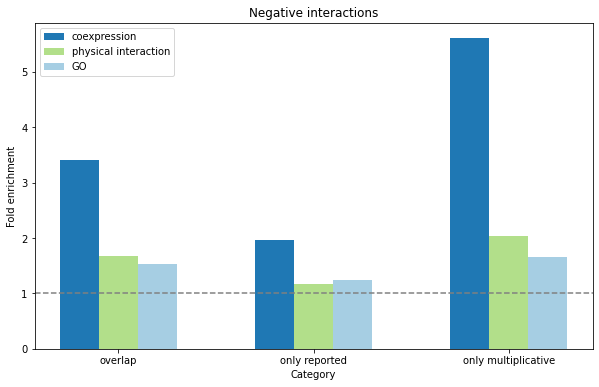

In [24]:
fig, axs = plt.subplots(figsize=(10,6))

x = np.arange(len(data[0]))
width = 0.2

plt.bar(x-width, data[0], width, color='#1f78b4')
plt.bar(x, data[1], width, color='#b2df8a')
plt.bar(x+width, data[2], width, color='#a6cee3')
plt.xticks(x, ['overlap', 'only reported', 'only multiplicative'])
plt.xlabel("Category")
plt.ylabel("Fold enrichment")
plt.legend(["coexpression", "physical interaction", "GO"])
plt.title("Negative interactions")
plt.axhline(1, linestyle="--", color="gray")
plt.show()

In [25]:
p = 0.05
data = []
for func in [enrich.fraction_coex_twoplus, enrich.fraction_three_shared, enrich.alleles_2_go_enrichment]:
    genome_wide = func(df)
    overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", func, multiplicative, tau_mult_sig_val)

    d = [overlap['frac']/genome_wide['frac'], only_reported['frac']/genome_wide['frac'], only_mult['frac']/genome_wide['frac']]
    data.append( d )

data = np.transpose(data)

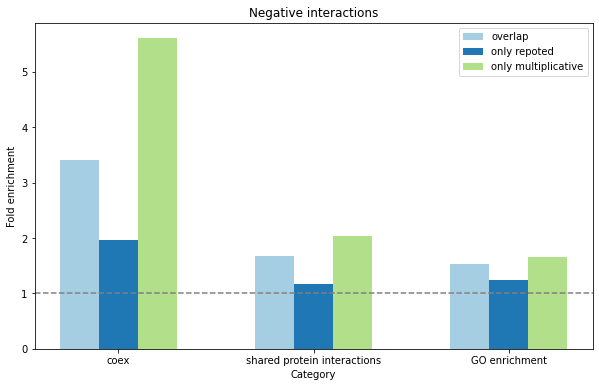

In [26]:
fig, axs = plt.subplots(figsize=(10,6))

x = np.arange(len(data[0]))
width = 0.2

plt.bar(x-width, data[0], width, color='#a6cee3')
plt.bar(x, data[1], width, color='#1f78b4')
plt.bar(x+width, data[2], width, color='#b2df8a')
plt.xticks(x, ['coex', 'shared protein interactions', 'GO enrichment'])
plt.xlabel("Category")
plt.ylabel("Fold enrichment")
plt.legend(["overlap", "only repoted", "only multiplicative"])
plt.title("Negative interactions")
plt.axhline(1, linestyle="--", color="gray")
plt.show()

3077


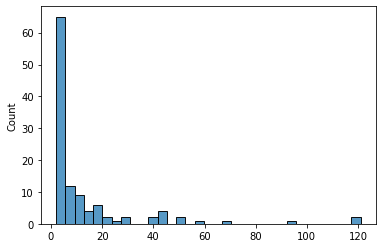

In [27]:
#tmp = df[(df.pval <= 0.05) & (df[multiplicative] <= tau_mult_sig_val['neg'])]
tmp = df[(df.pval <= 0.05) & (df.adjusted_interaction_score_epsilon_or_tau <= -0.08) & (df[multiplicative] <= tau_mult_sig_val['neg'])]

x = defaultdict(int)
for i,r in tmp.iterrows():
    a = r['alleles'].split(',')
    a = [i.split('-')[0] for i in a]
    x[(a[0],a[1])] += 1
    x[(a[0],a[2])] += 1
    x[(a[1],a[2])] += 1

d = list(x.values())
sns.histplot([i for i in d if i > 1])
print(len([i for i in d if i == 1]))


4106


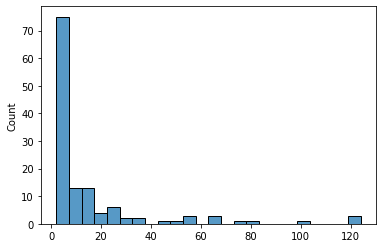

In [28]:
tmp = df[(df.pval <= 0.05) & (df[multiplicative] <= tau_mult_sig_val['neg'])]
#tmp = df[(df.pval <= 0.05) & (df.adjusted_interaction_score_epsilon_or_tau <= -0.08) & (df[multiplicative] <= tau_mult_sig_val['neg'])]

x = defaultdict(int)
for i,r in tmp.iterrows():
    a = r['alleles'].split(',')
    a = [i.split('-')[0] for i in a]
    x[(a[0],a[1])] += 1
    x[(a[0],a[2])] += 1
    x[(a[1],a[2])] += 1

d = list(x.values())
sns.histplot([i for i in d if i > 1])
print(len([i for i in d if i == 1]))